In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import torchaudio


# import torchaudio
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Model, Wav2Vec2Processor, Trainer, TrainingArguments, Wav2Vec2ForSequenceClassification

import warnings
warnings.filterwarnings('ignore')

c:\Users\hugph\speech-recognition\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
paths = []
labels = []
for dirname, _, filenames in os.walk("TESS Toronto emotional speech set data"):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split("_")[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
    if len(paths) == 2800:
        break



In [3]:
len(paths)

2800

In [4]:
paths[:5]

['TESS Toronto emotional speech set data\\OAF_angry\\OAF_back_angry.wav',
 'TESS Toronto emotional speech set data\\OAF_angry\\OAF_bar_angry.wav',
 'TESS Toronto emotional speech set data\\OAF_angry\\OAF_base_angry.wav',
 'TESS Toronto emotional speech set data\\OAF_angry\\OAF_bath_angry.wav',
 'TESS Toronto emotional speech set data\\OAF_angry\\OAF_bean_angry.wav']

In [5]:
labels[:5]

['angry', 'angry', 'angry', 'angry', 'angry']

In [6]:
df = pd.DataFrame()
df['audio_paths'] = paths
df['labels'] = labels
df.head()

,audio_paths,labels
0,TESS Toronto emotional speech set data\OAF_ang...,angry
1,TESS Toronto emotional speech set data\OAF_ang...,angry
2,TESS Toronto emotional speech set data\OAF_ang...,angry
3,TESS Toronto emotional speech set data\OAF_ang...,angry
4,TESS Toronto emotional speech set data\OAF_ang...,angry


In [7]:
df['labels'].value_counts()

labels
angry      400
disgust    400
fear       400
happy      400
neutral    400
ps         400
sad        400
Name: count, dtype: int64

<Axes: xlabel='labels', ylabel='count'>

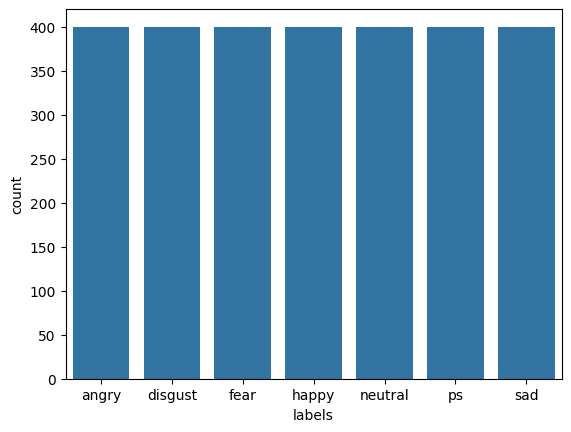

In [8]:
sns.countplot(data = df, x = 'labels')

In [9]:
def waveplot(data, sr, emotion):
    plt.figure(figsize = (10,4))
    plt.title(emotion, size = 20)
    librosa.display.waveshow(data, sr = sr)
    plt.show()

def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size = 20)
    librosa.display.specshow(xdb, sr = sr, x_axis = 'time', y_axis = 'hz')
    plt.colorbar()

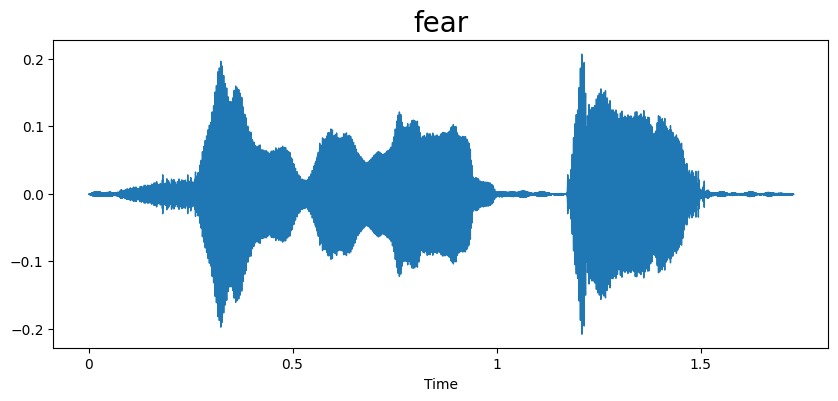

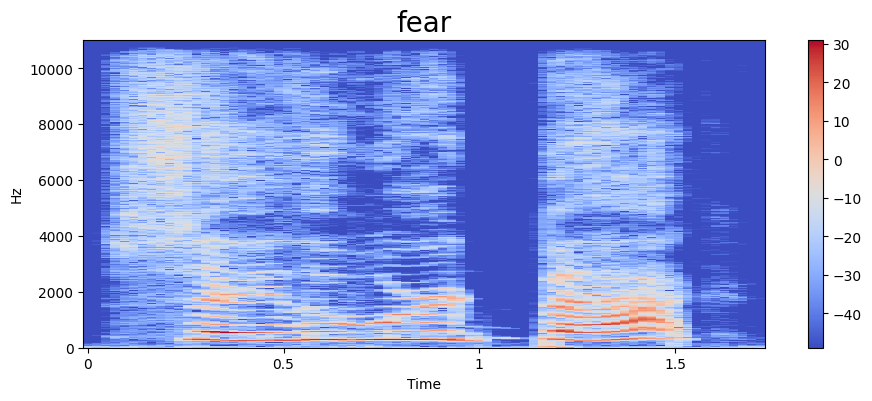

In [10]:
emotion = 'fear'
path = np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

In [11]:
label_map = {label: idx for idx, label in enumerate(df['labels'].unique())}
inverse_level_map = {idx: label for label, idx in label_map.items()}
df['labels'] = df['labels'].map(label_map)
df.head(2)

,audio_paths,labels
0,TESS Toronto emotional speech set data\OAF_ang...,0
1,TESS Toronto emotional speech set data\OAF_ang...,0


In [ ]:
# Ensure torchaudio is imported

class SpeechEmotionDataset(Dataset):
    def __init__(self, df, processor, max_length = 16000):
        self.df = df
        self.processor = processor
        self.max_length = max_length
    
    def __len__(self):
        return len(self.df)
    def __getItem__(self, idx):
        audio_path = self.df.iloc[idx]['audio_paths']
        label = self.df.iloc[idx]['label']

        speech, _ = torchaudio.load(audio_path)

        speech = torchaudio.functional.resample(speech, orig_freq = sr, new_freq = 16000)
        speech = speech.squeeze().numpy()

        if len(speech) == self.max_length:
            speech = speech[:self.max_length]
        else:
            speech = np.pad(speech, (0, self.max_length == len(speech)), 'constant')
        
        inputs = self.processor(speech, sampling_rate = 22050, return_tensors = 'pt', padding = True, truncate = True, max_length = self.max_length)

        input_values = inputs.input_values.squeeze()
        return {'input_values' : input_values, }

In [13]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state = 42)

In [14]:
processor = Wav2Vec2Processor.from_pretrained('facebook/wav2vec2-base')
model = Wav2Vec2ForSequenceClassification.from_pretrained('facebook/wav2vec2-base', num_labels = 7)

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
train_dataset = SpeechEmotionDataset(train_df, processor)
test_dataset = SpeechEmotionDataset(test_df, processor)

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size = 8, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 8, shuffle = False)

In [17]:
training_args = TrainingArguments(
    output_dir = './results',
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    learning_rate = 2e-5,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    num_train_epochs = 3,
    weight_decay = 0.01,
    report_to=[]
)

In [18]:
emotion = 'ps'
path = np.array(df['audio_paths'][df['labels']==2])[0]
data, sampling_rate = librosa.load(path)
len(data)
sampling_rate

22050

In [19]:
df['audio_paths'][df['labels'] == 2]

400     TESS Toronto emotional speech set data\OAF_Fea...
401     TESS Toronto emotional speech set data\OAF_Fea...
402     TESS Toronto emotional speech set data\OAF_Fea...
403     TESS Toronto emotional speech set data\OAF_Fea...
404     TESS Toronto emotional speech set data\OAF_Fea...
                              ...                        
1995    TESS Toronto emotional speech set data\TESS To...
1996    TESS Toronto emotional speech set data\TESS To...
1997    TESS Toronto emotional speech set data\TESS To...
1998    TESS Toronto emotional speech set data\TESS To...
1999    TESS Toronto emotional speech set data\TESS To...
Name: audio_paths, Length: 400, dtype: object

In [20]:
df['labels']

0       0
1       0
2       0
3       0
4       0
       ..
2795    6
2796    6
2797    6
2798    6
2799    6
Name: labels, Length: 2800, dtype: int64